In [180]:
import sys
sys.path.append('../_amigocloud')

In [181]:
import simplekml

In [182]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
#from shapely.geometry import Point, MultiPoint
import os
#from fastkml import kml

In [183]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [184]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [185]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

path_plan = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'

path_kml = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN'

path_xlsx_parte = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\PARTE DIARIO TRICHOGRAMMA 2024_RES.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [247]:
ors =70

In [248]:
gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [249]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


In [250]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
121,2641,CRONENBOLD AGUILERA ROBERTO,70,0,None,None,"MULTIPOINT (479135.810 8076122.178, 473579.894..."
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,"MULTIPOINT (465926.783 8085322.279, 466213.967..."
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,"MULTIPOINT (478915.849 8087454.484, 478999.431..."


In [251]:
multipoint_gdf = gdf_puntos_sem

In [252]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [253]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
121,2641,CRONENBOLD AGUILERA ROBERTO,70,0,None,None,POINT (479135.810 8076122.178)
121,2641,CRONENBOLD AGUILERA ROBERTO,70,0,None,None,POINT (473579.894 8076537.071)
121,2641,CRONENBOLD AGUILERA ROBERTO,70,0,None,None,POINT (473497.385 8076809.204)
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,POINT (465926.783 8085322.279)
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,POINT (466213.967 8085291.820)
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,POINT (466414.125 8085420.183)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (478915.849 8087454.484)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (478999.431 8087465.882)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479081.745 8087183.479)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479269.170 8087413.960)


<Axes: >

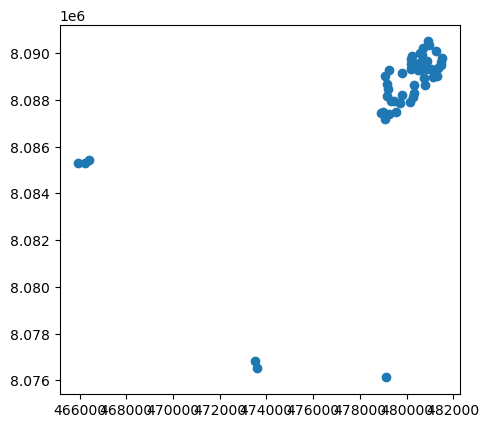

In [254]:
puntos_indi.plot()

In [255]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [256]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono de siembras
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [257]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,POINT (465926.783 8085322.279)
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,POINT (466213.967 8085291.820)
122,15284,ROJAS CORDOVA ROGELIO FELIPE,70,0,None,None,POINT (466414.125 8085420.183)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (478915.849 8087454.484)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (478999.431 8087465.882)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479081.745 8087183.479)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479269.170 8087413.960)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479540.175 8087505.139)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479149.897 8088187.045)
123,75,AGUILERA TARADELLES NELSON MARIANO,70,0,None,None,POINT (479344.677 8087952.073)


In [258]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [259]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [260]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
1243,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L12.3,8.204334,6,50,"POLYGON ((479596.661 8087720.023, 479674.968 8..."
1244,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.2,4.136542,7,50,"POLYGON ((480005.170 8089283.909, 480003.545 8..."
1245,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L8,13.870985,1,50,"POLYGON ((479533.887 8088300.002, 479542.301 8..."
1247,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L6.2,10.652102,0,50,"POLYGON ((479481.372 8088481.094, 479500.698 8..."
1248,256,LOS ANDES--AGUILERA,577,AGUILERA MARIA INGRID WENDE DE,L15,26.152852,1,50,"POLYGON ((480608.771 8088353.223, 480025.920 8..."
1249,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L18,11.943984,1,50,"POLYGON ((481128.361 8089209.660, 481085.001 8..."
2587,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L19.1,4.286588,4,50,"POLYGON ((481274.947 8089536.695, 481744.151 8..."
2699,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.2,11.052854,1,50,"POLYGON ((481046.124 8088827.511, 480569.041 8..."
2913,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.3,10.439605,3,50,"POLYGON ((480003.402 8089602.391, 480421.762 8..."
2914,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.1,9.807566,3,50,"POLYGON ((480921.637 8089070.106, 480528.480 8..."


In [261]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [262]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
1243,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L12.3,8.204334,6,50,"POLYGON ((479596.661 8087720.023, 479674.968 8..."
1244,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.2,4.136542,7,50,"POLYGON ((480005.170 8089283.909, 480003.545 8..."
1245,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L8,13.870985,1,50,"POLYGON ((479533.887 8088300.002, 479542.301 8..."
1247,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L6.2,10.652102,0,50,"POLYGON ((479481.372 8088481.094, 479500.698 8..."
1248,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L15,26.152852,1,50,"POLYGON ((480608.771 8088353.223, 480025.920 8..."
1249,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L18,11.943984,1,50,"POLYGON ((481128.361 8089209.660, 481085.001 8..."
2587,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L19.1,4.286588,4,50,"POLYGON ((481274.947 8089536.695, 481744.151 8..."
2699,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.2,11.052854,1,50,"POLYGON ((481046.124 8088827.511, 480569.041 8..."
2913,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.3,10.439605,3,50,"POLYGON ((480003.402 8089602.391, 480421.762 8..."
2914,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.1,9.807566,3,50,"POLYGON ((480921.637 8089070.106, 480528.480 8..."


In [263]:
# agrega los campos faltantes
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['os'] = ors

In [264]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os
1243,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L12.3,8.204334,6,50,"POLYGON ((479596.661 8087720.023, 479674.968 8...",,SOLICITUD,0,,70
1244,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.2,4.136542,7,50,"POLYGON ((480005.170 8089283.909, 480003.545 8...",,SOLICITUD,0,,70
1245,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L8,13.870985,1,50,"POLYGON ((479533.887 8088300.002, 479542.301 8...",,SOLICITUD,0,,70
1247,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L6.2,10.652102,0,50,"POLYGON ((479481.372 8088481.094, 479500.698 8...",,SOLICITUD,0,,70
1248,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L15,26.152852,1,50,"POLYGON ((480608.771 8088353.223, 480025.920 8...",,SOLICITUD,0,,70
1249,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L18,11.943984,1,50,"POLYGON ((481128.361 8089209.660, 481085.001 8...",,SOLICITUD,0,,70
2587,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L19.1,4.286588,4,50,"POLYGON ((481274.947 8089536.695, 481744.151 8...",,SOLICITUD,0,,70
2699,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.2,11.052854,1,50,"POLYGON ((481046.124 8088827.511, 480569.041 8...",,SOLICITUD,0,,70
2913,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.3,10.439605,3,50,"POLYGON ((480003.402 8089602.391, 480421.762 8...",,SOLICITUD,0,,70
2914,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.1,9.807566,3,50,"POLYGON ((480921.637 8089070.106, 480528.480 8...",,SOLICITUD,0,,70


In [265]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, multipoint_gdf, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['os'] = ors

In [266]:
# crea el campo soca, y coloca 0 o 1 dependiendo del origen
poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)

In [267]:
poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
       'fecha_ini', 'origen', 'dias', 'fecha', 'prioridad', 'inst', 'geometry', 'os', 'soca']]

In [268]:
poligonos_intersect_siem

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,inst,geometry,os,soca
499,1520,VILLA COPACABANA - CRONENBOLD,2641,CRONENBOLD AGUILERA ROBERTO,L35,3.183414,2024-04-30,SIEMBRA 2024,95.0,2024-04-30,2,0.0,"POLYGON ((473450.191 8076965.012, 473500.331 8...",70,0
500,558,NARANJAL--MARTA S. AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L7,6.315265,2024-04-10,SIEMBRA 2024,115.0,2024-04-10,2,0.0,"POLYGON ((479162.628 8076488.740, 479247.562 8...",70,0
516,1520,VILLA COPACABANA - CRONENBOLD,2641,CRONENBOLD AGUILERA ROBERTO,L34,5.205523,2024-04-29,SIEMBRA 2024,96.0,2024-04-29,2,0.0,"POLYGON ((473371.713 8076895.269, 473438.999 8...",70,0


In [269]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

<Axes: >

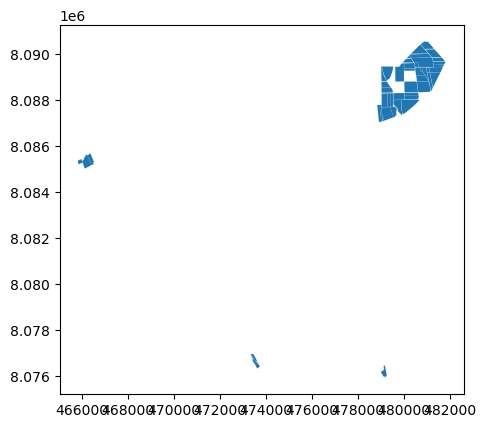

In [270]:
plan.plot()

In [271]:
plan['area'].sum()

498.005360859947

In [272]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [273]:
plan['area'].sum()

498.005360859851

In [274]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [275]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [276]:
last_id

1213

In [277]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [278]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L12.3,8.204334,6,50,"POLYGON ((479596.661 8087720.023, 479674.968 8...",,SOLICITUD,0.0,,70,NaN,1214
1,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.2,4.136542,7,50,"POLYGON ((480005.170 8089283.909, 480003.545 8...",,SOLICITUD,0.0,,70,NaN,1215
2,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L8,13.870985,1,50,"POLYGON ((479533.887 8088300.002, 479542.301 8...",,SOLICITUD,0.0,,70,NaN,1216
3,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L6.2,10.652102,0,50,"POLYGON ((479481.372 8088481.094, 479500.698 8...",,SOLICITUD,0.0,,70,NaN,1217
4,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L15,26.152852,1,50,"POLYGON ((480608.771 8088353.223, 480025.920 8...",,SOLICITUD,0.0,,70,NaN,1218
5,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L18,11.943984,1,50,"POLYGON ((481128.361 8089209.660, 481085.001 8...",,SOLICITUD,0.0,,70,NaN,1219
6,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L19.1,4.286588,4,50,"POLYGON ((481274.947 8089536.695, 481744.151 8...",,SOLICITUD,0.0,,70,NaN,1220
7,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.2,11.052854,1,50,"POLYGON ((481046.124 8088827.511, 480569.041 8...",,SOLICITUD,0.0,,70,NaN,1221
8,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.3,10.439605,3,50,"POLYGON ((480003.402 8089602.391, 480421.762 8...",,SOLICITUD,0.0,,70,NaN,1222
9,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.1,9.807566,3,50,"POLYGON ((480921.637 8089070.106, 480528.480 8...",,SOLICITUD,0.0,,70,NaN,1223


In [279]:
len(plan)

50

In [280]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [281]:
gdf_pla_gral['area'].sum()

8918.542984846275

In [282]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [283]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

In [284]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,...,os,soca,id,inst,telefono_1,telefono_2,telefono_3,idd,asignado,geometry
0,47,SANTA MARTHA,40149,PAZ REA JOSE ERNESTO,A7,10.696703,21/5/2024,SIEMBRA 2023,37,2024-05-21,...,26,1,1,69,0.0,0.0,0.0,35,None,"POLYGON ((488616.298 8103763.516, 488519.488 8..."
1,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L7.2,1.835936,2024-04-15,SIEMBRA 2024,73,2024-04-15,...,26,0,2,62,0.0,0.0,0.0,54,None,"POLYGON ((473330.370 8101634.734, 473440.011 8..."
2,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L6,1.960231,2024-04-15,SIEMBRA 2024,73,2024-04-15,...,26,0,3,62,0.0,0.0,0.0,54,None,"POLYGON ((473242.172 8101427.289, 473148.580 8..."
3,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L9.1,3.607907,2024-04-16,SIEMBRA 2024,72,2024-04-16,...,26,0,4,62,0.0,0.0,0.0,54,None,"POLYGON ((473286.579 8101086.503, 473265.875 8..."
4,2123,LAS CHACRAS PORTACHUELO,13132,ZUMARAN MENACHO JORGE,L1.6,0.386826,2024-04-22,SIEMBRA 2024,66,2024-04-22,...,26,0,5,50,0.0,0.0,0.0,63,None,"POLYGON ((455236.898 8084312.120, 455248.807 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,256,LOS_ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L5,6.570389,,SOLICITUD,0,,...,70,2,1259,50,NaN,NaN,NaN,NaN,NaN,"POLYGON ((479237.523 8088827.119, 479017.653 8..."
1151,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L13.2,28.214910,,SOLICITUD,0,,...,70,1,1260,50,NaN,NaN,NaN,NaN,NaN,"POLYGON ((479878.607 8088011.878, 480198.092 8..."
1152,1520,VILLA COPACABANA - CRONENBOLD,2641,CRONENBOLD AGUILERA ROBERTO,L35,3.183414,2024-04-30,SIEMBRA 2024,95,2024-04-30,...,70,0,1261,0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((473450.191 8076965.012, 473500.331 8..."
1153,558,NARANJAL--MARTA S. AGUILERA,2641,CRONENBOLD AGUILERA ROBERTO,L7,6.315265,2024-04-10,SIEMBRA 2024,115,2024-04-10,...,70,0,1262,0,NaN,NaN,NaN,NaN,NaN,"POLYGON ((479162.628 8076488.740, 479247.562 8..."


# CARGAR PLANIFICACION A AMIGOCLOUD

In [285]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [286]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [287]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [288]:
len(gdf_pla_gral)

50

In [289]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR KMLS DE PLANIFICACION

In [290]:
gdf_plan = gpd.read_file(path_plan)

In [291]:
gdf_plan_sem = gdf_plan[gdf_plan['os'] == ors]
gdf_plan_sem['area'].sum()

498.005360859851

In [292]:
lista_cods = list(set(gdf_plan_sem['unidad_01']))

In [293]:
lista_cods

[256, 1345, 1520, 558]

In [294]:
for i in lista_cods:
    prop = gdf_plan_sem[gdf_plan_sem['unidad_01'] == i]
    prop_wgs = prop.to_crs(epsg=4326)
    output_folder = path_kml + '\\' + str(i)
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Recorrer el GeoDataFrame
    for idx, row in prop_wgs.iterrows():
        # Crear un nuevo documento KML
        kml_doc = simplekml.Kml()
        # Obtener el polígono y el nombre
        polygon = row['geometry']
        name = row['unidad_05']
        # Convertir el polígono en una lista de coordenadas
        coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]    
        # Añadir el polígono al documento KML
        pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
        # Guardar el archivo KML
        file_name = f"{name}.kml"
        output_path = os.path.join(output_folder, file_name)
        kml_doc.save(output_path)

G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\256
G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\1345
G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\1520
G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\558


# CARGAR XLSX

In [295]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [296]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [297]:
excel_data = pd.read_excel(path_xlsx_parte)

In [298]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L12.3,8.204334,6,50,"MULTIPOLYGON (((-63.19199 -17.29572, -63.19125...",,SOLICITUD,0,,70,NaN,1214
1,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.2,4.136542,7,50,"MULTIPOLYGON (((-63.18813 -17.28159, -63.18814...",,SOLICITUD,0,,70,NaN,1215
2,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L8,13.870985,1,50,"MULTIPOLYGON (((-63.19257 -17.29048, -63.19249...",,SOLICITUD,0,,70,NaN,1216
3,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L6.2,10.652102,0,50,"MULTIPOLYGON (((-63.19306 -17.28884, -63.19288...",,SOLICITUD,0,,70,NaN,1217
4,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L15,26.152852,1,50,"MULTIPOLYGON (((-63.18246 -17.29001, -63.18794...",,SOLICITUD,0,,70,NaN,1218
5,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L18,11.943984,1,50,"MULTIPOLYGON (((-63.17756 -17.28227, -63.17797...",,SOLICITUD,0,,70,NaN,1219
6,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L19.1,4.286588,4,50,"MULTIPOLYGON (((-63.17618 -17.27932, -63.17176...",,SOLICITUD,0,,70,NaN,1220
7,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.2,11.052854,1,50,"MULTIPOLYGON (((-63.17834 -17.28572, -63.18283...",,SOLICITUD,0,,70,NaN,1221
8,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L3.3,10.439605,3,50,"MULTIPOLYGON (((-63.18814 -17.27871, -63.18421...",,SOLICITUD,0,,70,NaN,1222
9,256,LOS ANDES--AGUILERA,75,AGUILERA TARADELLES NELSON MARIANO,L1.1,9.807566,3,50,"MULTIPOLYGON (((-63.17951 -17.28353, -63.18321...",,SOLICITUD,0,,70,NaN,1223


In [299]:
list(gdf_pla_gral['unidad_01'])

[256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 1345,
 1345,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 1345,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 256,
 1520,
 558,
 1520]

In [300]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'FINANCIADO': list(gdf_pla_gral['origen']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [301]:
new_df['PRODUCTO'] = 'TRICHOGRAMMA'
new_df['DOSIS'] = '6ml'

In [302]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,FINANCIADO,ID,OS,PRODUCTO,DOSIS
0,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L12.3,8.204334,6,SOLICITUD,1214,70,TRICHOGRAMMA,6ml
1,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L3.2,4.136542,7,SOLICITUD,1215,70,TRICHOGRAMMA,6ml
2,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L8,13.870985,1,SOLICITUD,1216,70,TRICHOGRAMMA,6ml
3,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L6.2,10.652102,0,SOLICITUD,1217,70,TRICHOGRAMMA,6ml
4,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L15,26.152852,1,SOLICITUD,1218,70,TRICHOGRAMMA,6ml
5,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L18,11.943984,1,SOLICITUD,1219,70,TRICHOGRAMMA,6ml
6,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L19.1,4.286588,4,SOLICITUD,1220,70,TRICHOGRAMMA,6ml
7,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L1.2,11.052854,1,SOLICITUD,1221,70,TRICHOGRAMMA,6ml
8,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L3.3,10.439605,3,SOLICITUD,1222,70,TRICHOGRAMMA,6ml
9,50,75,AGUILERA TARADELLES NELSON MARIANO,256,LOS ANDES--AGUILERA,L1.1,9.807566,3,SOLICITUD,1223,70,TRICHOGRAMMA,6ml


In [303]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [304]:
final_data.to_excel(path_xlsx_parte, index=False)